## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [183]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic
from skimage.morphology import remove_small_objects
from matplotlib import patches
from matplotlib.axes import Axes

from enum import Enum
from typing import Any, List, Literal

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

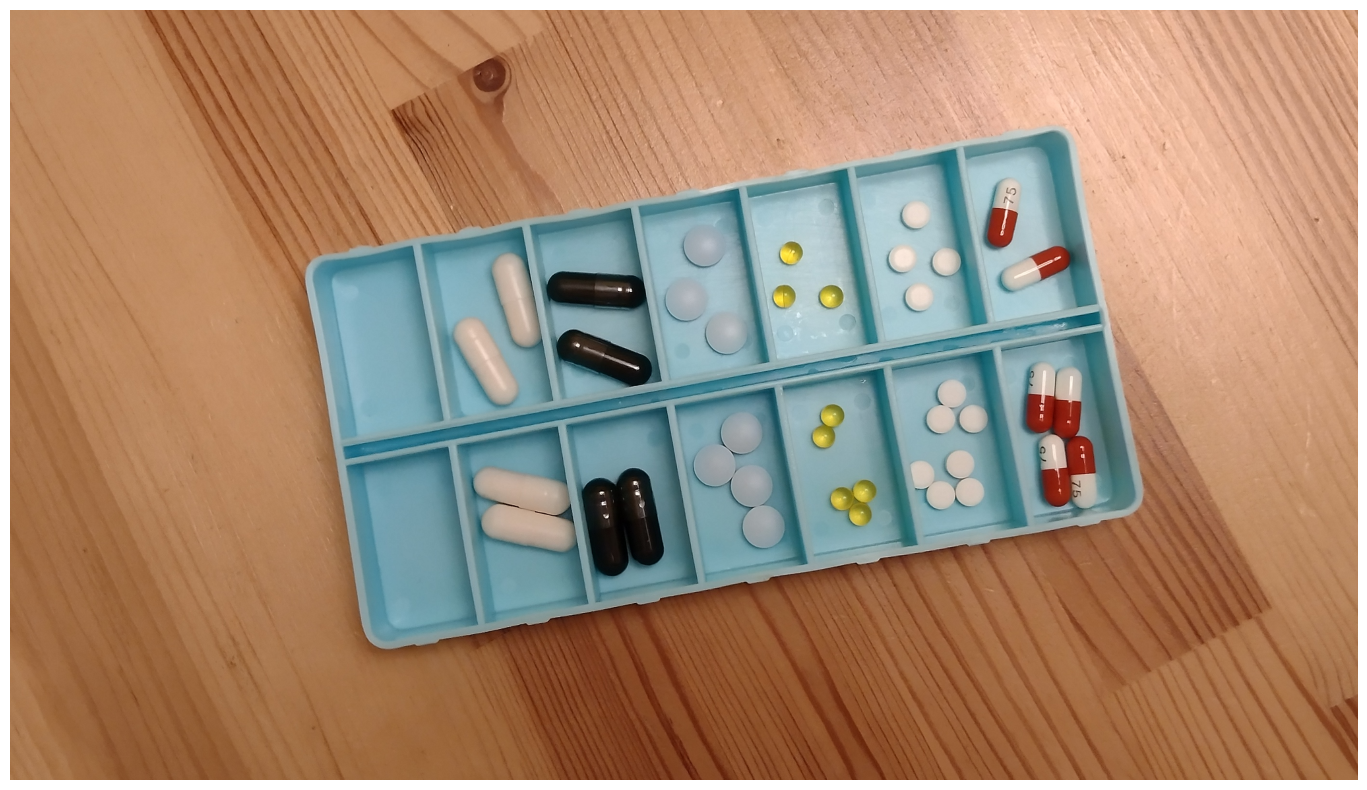

In [264]:
calib = cv2.imread('calib.png')
fig, ax = plt.subplots(figsize=(25, 10))
ax.axis('off')
ax.imshow(calib[..., ::-1]);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [185]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [276]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}

class PillDetector:
    RGB = 'RGB'
    BGR = 'BGR'
    HSV = 'HSV'
    GRAY = 'GRAY'
    LAB = 'LAB'

    def __init__(self, input_color_space: Literal['BGR', 'RGB', 'HSV', 'GRAY', 'LAB'] ='BGR'):
        assert input_color_space in ['BGR', 'RGB', 'HSV', 'GRAY', 'LAB']
        self.__input_color_space = input_color_space
    
    @property
    def input_color_space(self):
        return self.__input_color_space
    
    def detect(self, src: np.ndarray):
        res = {
            PillType.KETO: self.__detect_keto(src),
            PillType.LINE: self.__detect_line(src),
            PillType.ESPU: self.__detect_espu(src),
            PillType.BIOX: self.__detext_biox(src),
            PillType.PROBIO: self.__detect_probio(src),
            PillType.CARBON: self.__detect_carbon(src)
        }
        return res
    
    def bbshow(self, src: np.ndarray, data: dict[PillType, list[np.ndarray]], ax: Axes, classify=True):
        for pil_type, bbs in data.items():
            color = COLORMAP[pil_type]
            for bb in bbs:
                x, y, w, h = bb
                if classify:
                    cv2.rectangle(src, (x, y), (x + w, y + h), color, 4)
                    cv2.putText(src, f'{pil_type.name}', (x, y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
                else:
                    cv2.rectangle(src, (x, y), (x + w, y + h), (200, 0, 0), 4)
        ax.imshow(src)
        return ax

    
    def __get_bb(self, mask: np.ndarray):
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return [cv2.boundingRect(contour) for contour in contours]

    def __detect_keto(self, src: np.ndarray) -> list[np.ndarray]:
        # przygotowanie binarnej maski HSV
        image = src.copy()
        image = self.to_hsv(image)
        image = image[..., 1].astype(np.uint8)
        _, hsv_mask = cv2.threshold(image, 40, 255, cv2.THRESH_BINARY_INV)
        
        # przygotowanie binarnej maski RGB
        image = src.copy()
        image = self.to_rgb(image)
        rgb_mask = cv2.inRange(image, (140, 140, 140), (190, 190, 190))
        
        # kombinacja obu masek
        mask = rgb_mask & hsv_mask

        # otwarcie morfologiczne - usuwanie szumu z tła
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (25, 25))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

        # erozja morfologiczne
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel)

        # odfiltrowanie za małych obiektów
        mask = remove_small_objects(mask > 0, min_size=2500)

        bbs = self.__get_bb(mask)
        return bbs

    def __detect_line(self, src: np.ndarray) -> list[np.ndarray]:
        # filtorwanie na kanałach RGB
        image = src.copy()
        image = self.to_rgb(image)
        image = cv2.inRange(image, (115, 0, 0), (255, 60, 60))

        # otwarcie morfologiczne - usunięcie szumów (z tła)
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (15, 15))
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

        # zamkniecie morfologiczne - usunięcie szumów (z obiektów)
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (10, 10))
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

        # odfiltrowanie za małych obiektów
        mask = remove_small_objects(image > 0, min_size=100)

        bbs = self.__get_bb(mask) 
        return bbs

    def __detect_espu(self, src: np.ndarray) -> list[np.ndarray]:
        # binaryzacja na kanale H z HSV
        image = src.copy()
        image = self.to_hsv(image)
        image = cv2.inRange(image[..., 0], 22, 30)

        # otwarcie morfologiczne - usuwanie szumów
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (15, 15))
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        
        # usunięcie za małych obiektów
        mask = remove_small_objects(image > 0, min_size=400)

        bbs = self.__get_bb(mask) 
        return bbs

    def __detext_biox(self, src: np.ndarray) -> list[np.ndarray]:
        # binaryzacja na szarości
        image = src.copy()
        image = self.to_gray(image)
        _, image = cv2.threshold(image, 187, 255, cv2.THRESH_BINARY)

        # maska organizera
        mask = src.copy()
        mask = self.to_hsv(mask)
        mask = cv2.inRange(mask[..., 0], 70, 190)
        mask = (255 - mask).astype(np.uint8)

        # maska stołu
        table_mask = cv2.cvtColor(src.copy(), cv2.COLOR_BGR2HSV)[..., 0].astype(np.uint8)
        _, table_mask = cv2.threshold(table_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (300, 300))
        table_mask = cv2.morphologyEx(table_mask, cv2.MORPH_CLOSE, kernel)

        # nałożenie masek
        image = mask & image & table_mask

        # otwarcie morfologiczne - usuwanie szumów
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (25, 25))
        mask = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

        bbs = self.__get_bb(mask) 
        return bbs
    
    def __detect_probio(self, src: np.ndarray) -> list[np.ndarray]:
        image = src.copy()
        # Progowanie na RGB
        image = self.to_rgb(image)
        image = cv2.inRange(image, (150, 170, 150), (255, 255, 180))

        # Otwarcie morfologiczne - usuwanie szumu
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

        # Dylatacja morfologiczna - uzupełnienie dziur w obiektach
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
        image = cv2.morphologyEx(image, cv2.MORPH_DILATE, kernel)

        # Odfiltrowanie za małych obiektów
        image = remove_small_objects(image > 0, min_size=3695)

        # Maska za dużych obiektów
        mask = image.copy()
        mask = remove_small_objects(image > 0, min_size=15000).astype(np.uint8)
        mask = cv2.bitwise_not(mask)

        # Nałożenie maski
        mask = image & mask

        bbs = self.__get_bb(mask) 
        return bbs
    
    def __detect_carbon(self, src: np.ndarray) -> list[np.ndarray]:
        # binaryzacja na kanale V z HSV
        image = src.copy()
        image = self.to_hsv(image)
        image = cv2.inRange(image[..., 2], 80, 255)

        # zanegowanie binaryzacji
        image = cv2.bitwise_not(image)

        # otwarcie morfologiczne - usuwanie szumów
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (15, 15))
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

        # dylatacja morfologiczna - uzupełnienie dziur w obiektach
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (25, 25))
        image = cv2.morphologyEx(image, cv2.MORPH_DILATE, kernel)

        # odfiltrowanie za małych obiektów
        mask = remove_small_objects(image > 0, min_size=2000)

        bbs = self.__get_bb(mask) 
        return bbs
        
    def __to(self, src: np.ndarray, target: str) -> np.ndarray:
        if self.__input_color_space == target:
            return src
        convertion_code = getattr(cv2, f'COLOR_{self.__input_color_space}2{target}')
        return cv2.cvtColor(src, convertion_code)
    
    def to_rgb(self, src: np.ndarray) -> np.ndarray:
        return self.__to(src, self.RGB)

    def to_bgr(self, src: np.ndarray) -> np.ndarray:
        return self.__to(src, self.BGR)
    
    def to_hsv(self, src: np.ndarray) -> np.ndarray:
        return self.__to(src, self.HSV)
    
    def to_gray(self, src: np.ndarray) -> np.ndarray:
        return self.__to(src, self.GRAY)
    
    def to_lab(self, src: np.ndarray) -> np.ndarray:
        return self.__to(src, self.LAB)

<Axes: >

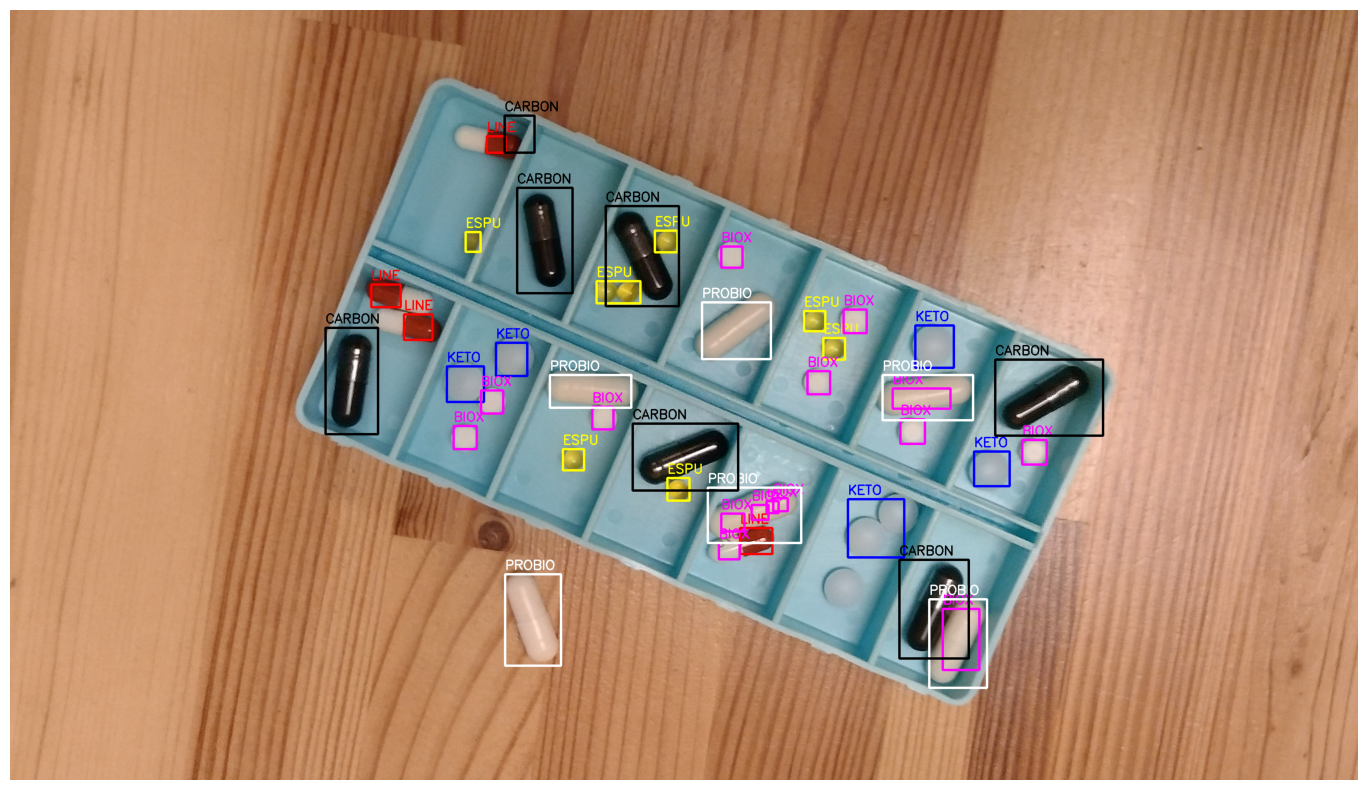

In [278]:
src = cv2.imread('calib.png')
src = cv2.imread('test_line.png')
fig, ax = plt.subplots(figsize=(25, 10))
ax.axis('off')
detector = PillDetector(input_color_space='BGR')
data = detector.detect(src)
detector.bbshow(detector.to_rgb(src), data, ax)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
szczegóły układu tej struktury są dowolne.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.